In [1]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 

channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

In [3]:
def LoadData_BSscans(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))       #This is for 10 Hz
      #  reprate_FEL = pulse_ids%10 == 0
        reprate_laser = pulse_ids%20 == 0                               #This is for 5 Hz
        
        PIPS_fluo_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        PIPS_fluo_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        PIPS_trans_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        PIPS_trans_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpumped = BS_file[channel_Izero][:][reprate_FEL]
        
        Delay = BS_file[channel_delay][:][reprate_FEL]
        Energy = BS_file[channel_energy][:][reprate_FEL]
        
    return PIPS_fluo_pumped, PIPS_fluo_unpumped, PIPS_trans_pumped, PIPS_trans_unpumped, Izero_pump, Izero_unpumped, Delay, Energy

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [4]:
DIR = "/sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/"
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

!ls -lah -rt /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 569G
drwxrwsr-x. 17 17589 p17589 4.0K Oct 29 05:29 ..
-rw-r--r--.  1 17589 p17589  18G Oct 29 05:32 monoscan_20uJ_143p515_Febpy_a_step0000.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 05:35 monoscan_20uJ_143p515_Febpy_a_step0000.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 05:35 monoscan_20uJ_143p515_Febpy_a_step0001.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 05:38 monoscan_20uJ_143p515_Febpy_a_step0001.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 05:39 monoscan_20uJ_143p515_Febpy_a_step0002.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 05:42 monoscan_20uJ_143p515_Febpy_a_step0002.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 05:42 monoscan_20uJ_143p515_Febpy_a_step0003.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 05:45 monoscan_20uJ_143p515_Febpy_a_step0003.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 29 05:46 monoscan_20uJ_143p515_Febpy_a_step0004.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 29 05:49 monoscan_20uJ_143p5

In [5]:
# this cell just to test if the channels are read correctly, you can skip it.

fileName = "monoscan_20uJ_143p515_Febpy_a_step0022.BSREAD.h5"

BS_file = h5py.File(DIR + fileName)
#print(list(BS_file["data"].keys()))

energy_test = BS_file[channel_energy][:]
pulse_ids = BS_file[channel_pulse_ids][:]
#Izero = BS_file["data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"] 
#Energy = BS_file["data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"]

In [6]:
print (pulse_ids.shape)
print (energy_test.shape)

(19991,)
(19991, 1)


In [7]:
scan_name = "monoscan_20uJ_143p515_Febpy_a"

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Fluo_pumped = []
err_fluo_pumped = []
Fluo_unpumped = []
err_fluo_unpumped = []
Izero_pumped = []
err_Izero_pumped = []
Izero_unpumped = []
err_Izero_unpumped = []
Delay_mm = []
Energy_eV = []

for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    (PIPS_fluo_pumped_loop,PIPS_fluo_unpumped_loop,PIPS_trans_pumped_loop,PIPS_trans_unpumped_loop,Izero_pumped_loop,Izero_unpumped_loop,delay_loop,energy_loop) = LoadData_BSscans(str(data['scan_files'][i][0]))
    Fluo_pumped.append(-PIPS_fluo_pumped_loop.mean())
    err_fluo_pumped.append(-PIPS_fluo_pumped_loop.std()/np.sqrt(PIPS_fluo_pumped_loop.size))
    Fluo_unpumped.append(-PIPS_fluo_unpumped_loop.mean())
    err_fluo_unpumped.append(-PIPS_fluo_unpumped_loop.std()/np.sqrt(PIPS_fluo_unpumped_loop.size))
    
    Izero_pumped.append(Izero_pumped_loop.mean())
    err_Izero_pumped.append(Izero_pumped_loop.std()/np.sqrt(Izero_pumped_loop.size))
    Izero_unpumped.append(Izero_unpumped_loop.mean())
    err_Izero_unpumped.append(Izero_unpumped_loop.std()/np.sqrt(Izero_unpumped_loop.size))
    
    energy_loop = [x for x in energy_loop if (x > 0)]     #This is to prevent that some occasional zeros screw up the mean value calculated below
    delay_loop = [x for x in delay_loop if (x > 0)]       #This is to prevent that some occasional zeros screw up the mean value calculated below
    Delay_mm.append(np.mean(delay_loop))
    Energy_eV.append(np.mean(energy_loop))
    
Fluo_pumped = np.asarray(Fluo_pumped)
err_fluo_pumped = np.asarray(err_fluo_pumped)
Fluo_unpumped = np.asarray(Fluo_unpumped)
err_fluo_unpumped = np.asarray(err_fluo_unpumped)
Izero_pumped = np.asarray(Izero_pumped)
err_Izero_pumped = np.asarray(err_Izero_pumped)
Izero_unpumped = np.asarray(Izero_unpumped)
err_Izero_unpumped = np.asarray(err_Izero_unpumped)
Delay_mm = np.asarray(Delay_mm)
Energy_eV = np.asarray(Energy_eV)

/sf/alvra/data/p17589/res/scan_info/monoscan_20uJ_143p515_Febpy_a_scan_info.json
Processing 29 files
step 1 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0000.BSREAD.h5
step 2 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0001.BSREAD.h5
step 3 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0002.BSREAD.h5
step 4 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0003.BSREAD.h5
step 5 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0004.BSREAD.h5
step 6 of 29 : Processing /sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/monoscan_20uJ_143p515_Febpy_a_step0005.BSREAD.h5
step 7 of 29 : Processing /sf/alvra/data/p17589/raw/s

In [8]:
print (PIPS_fluo_pumped_loop.size)
print (PIPS_fluo_unpumped_loop.size)

1000
1000


In [9]:
XAS_pump_norm = Fluo_pumped / Izero_pumped
err_XAS_pumped_norm = err_fluo_pumped / Izero_pumped

XAS_unpumped_norm = Fluo_unpumped / Izero_unpumped
err_XAS_unpumped_norm = err_fluo_unpumped / Izero_unpumped

XAS_diff = XAS_pump_norm - XAS_unpumped_norm
Delay_ps = (Delay_mm - 143)*3.333

In [10]:
Fluo_unpumped

array([0.39000122, 0.3715708 , 0.41277588, 0.42030322, 0.42941846,
       0.44350366, 0.42350269, 0.49818652, 0.52344946, 0.52127539,
       0.53781543, 0.53511816, 0.55061572, 0.57497827, 0.59128345,
       0.6093147 , 0.61798169, 0.61663135, 0.6851814 , 0.68753882,
       0.76329785, 0.81414282, 0.78671069, 0.78939917, 0.80844873,
       0.86430176, 0.79633862, 0.75940063, 0.72422998])

### Run the following cell if you want to plot pump-probe XAS data (with also ON & OFF spectra)

<IPython.core.display.Javascript object>


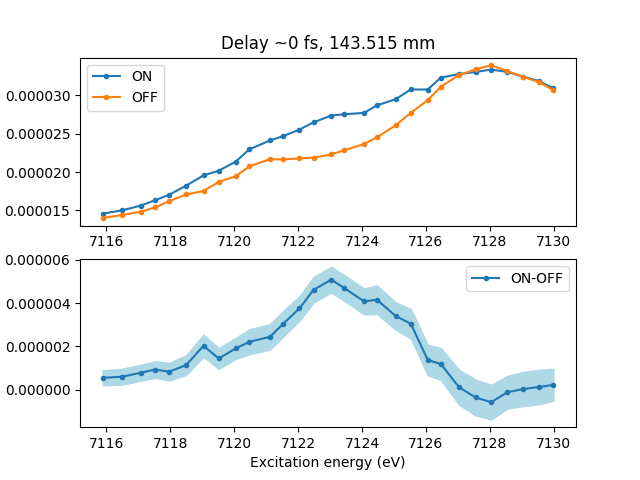

In [11]:
plt.figure()
plt.subplot(211)
plt.plot(Energy_eV, XAS_pump_norm, label="ON", marker='.')
plt.plot(Energy_eV, XAS_unpumped_norm, label="OFF", marker='.')
plt.legend(loc="best")
plt.title("Delay ~0 fs, 143.515 mm")
plt.ylabel("XAS norm")

low_err= (XAS_diff) - np.sqrt(err_XAS_pumped_norm**2+err_XAS_unpumped_norm**2)
high_err= (XAS_diff) + np.sqrt(err_XAS_pumped_norm**2+err_XAS_unpumped_norm**2)

plt.subplot(212)
plt.plot(Energy_eV, XAS_diff, label="ON-OFF", marker='.')
plt.fill_between(np.squeeze(Energy_eV), low_err, high_err, color='lightblue')
plt.legend(loc="best")
plt.ylabel("XAS Transient")
plt.xlabel("Excitation energy (eV)")
plt.show()
#plt.savefig('XAS_BS_170mm')

### Run the following cell if you want to plot pump-probe delay data (XAS in TFY vs delay at fixed energy)

<IPython.core.display.Javascript object>


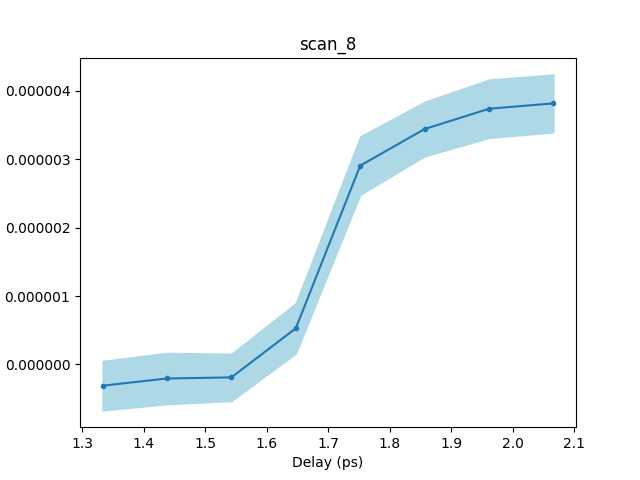

In [79]:
plt.figure()
plt.plot(Delay_ps, XAS_diff, marker='.')

low_err= (XAS_diff) - np.sqrt(err_XAS_pumped_norm**2+err_XAS_unpumped_norm**2)
high_err= (XAS_diff) + np.sqrt(err_XAS_pumped_norm**2+err_XAS_unpumped_norm**2)

plt.fill_between(np.squeeze(Delay_ps), low_err, high_err, color='lightblue')
plt.title("scan_8")
plt.xlabel("Delay (ps)")
plt.show()
#plt.savefig('Timescan_7_diode')